In [1]:
import logging
import torch
from torchsummary import summary
import torch.optim as optim
import torch.nn as nn
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import cv2
import torchvision.transforms.v2 as transforms
import numpy as np
from pothole.datasets import PotholeDataset
from pothole.training import train
from pothole.models.resnet import get_resnet_model
from torchvision.models import resnet50, ResNet50_Weights
import xml.etree.ElementTree as ET
import os
import matplotlib.pyplot as plt
import random
logging.basicConfig(level=logging.INFO, format='%(name)s: %(message)s')
from tqdm.notebook import tqdm
from sklearn.metrics import top_k_accuracy_score
from torcheval.metrics import BinaryPrecisionRecallCurve
import torch.nn.functional as F
from sklearn.metrics import precision_recall_curve


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
trainset = PotholeDataset(split='train', proposals_path="/home/mlut/IDLCV/object_detection/potholes_git/02516_pothole_w3/data/props-0.30-0.40.yml")


In [4]:
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=None,
    shuffle=True,
    num_workers=3,
)

In [5]:
valset = PotholeDataset(split='validation', proposals_path="/home/mlut/IDLCV/object_detection/potholes_git/02516_pothole_w3/data/props-0.30-0.45_validation.yml")


In [6]:
valsetloader = torch.utils.data.DataLoader(
    valset,
    batch_size=None,
    shuffle=False,
    num_workers=3,
)

In [18]:
testset = PotholeDataset(split='test', proposals_path="/home/mlut/IDLCV/object_detection/potholes_git/02516_pothole_w3/data/props-0.30-0.48_test.yml")

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=None,
    shuffle=False,
    num_workers=3,
)

In [7]:
batch_of_images = trainset[22]
image = batch_of_images[0][12]
#plt.imshow(image)

In [8]:
num_epochs = 10
loss_function = nn.BCEWithLogitsLoss()

In [9]:
model = get_resnet_model().to(device)

In [10]:
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=9e-1, weight_decay=5e-4)

In [11]:
losses = []
val_losses = []
for epoch in tqdm(range(num_epochs), unit='epoch'):
    model.train()  
    epoch_loss = []
    for X, y in trainloader:
        data, target = X.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target.float())  
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
    losses.append(sum(epoch_loss)/len(epoch_loss))

    all_outputs = []
    all_targets = []
    val_epoch_loss = []
    model.eval()
    with torch.no_grad():
        for X, y in valsetloader:
            data, target = X.to(device), y.to(device)
            output = model(data)
            probabilities = F.sigmoid(output).cpu().numpy()
            all_outputs.extend(probabilities)
            all_targets.extend(target.cpu().numpy())
            
            val_loss = loss_function(output, target.float())
            val_epoch_loss.append(val_loss.item())
        average_val_loss = sum(val_epoch_loss) / len(val_epoch_loss)
        val_losses.append(average_val_loss)


        


  0%|          | 0/10 [00:00<?, ?epoch/s]

In [ ]:
precision, recall, thresholds = precision_recall_curve(all_targets, all_outputs)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.title('Precision-Recall Curve', fontsize=25)
plt.show()
plt.savefig("precisoinrecallplotvalidation")

In [29]:
all_outputs_test = []
all_targets_test = []
with torch.no_grad():
    for X, y in testloader:
        data, target = X.to(device), y.to(device)
        output = model(data)
        all_outputs_test.extend(F.sigmoid(output).cpu().numpy())
        all_targets_test.extend(target.cpu().numpy())

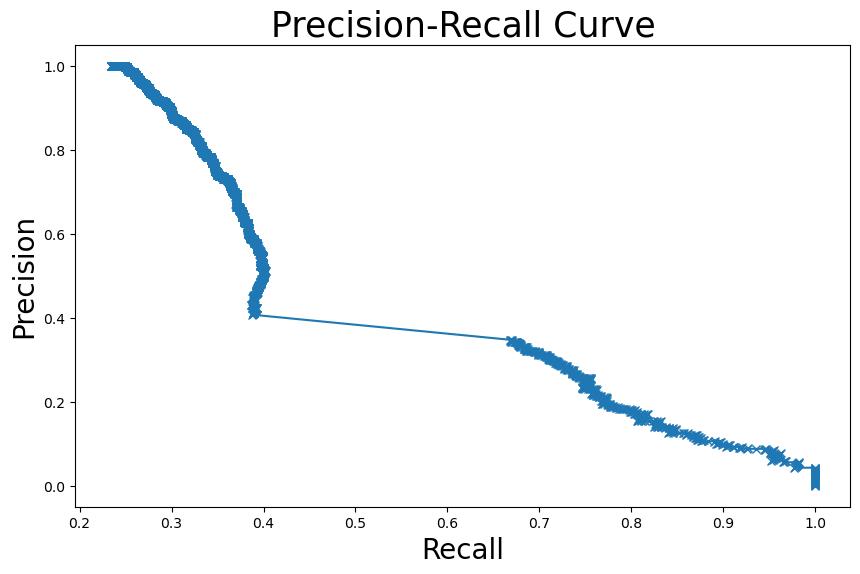

<Figure size 640x480 with 0 Axes>

In [31]:
plt.figure(figsize=(10, 6))

precision_test, recall_test, thresholds = precision_recall_curve(all_targets_test, all_outputs_test)
plt.plot(precision_test, recall_test, marker='x', label='Test')

plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.title('Precision-Recall Curve', fontsize=25)
plt.show()

plt.savefig("precision_recall_plot.png")  # Save the plot as a file


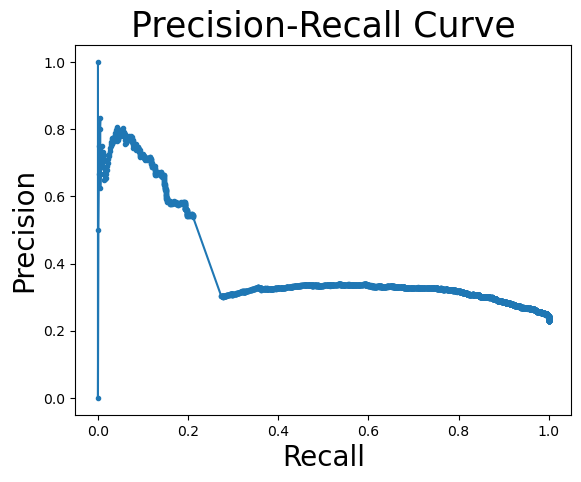

<Figure size 640x480 with 0 Axes>

In [17]:
precision, recall, thresholds = precision_recall_curve(all_targets, all_outputs)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.title('Precision-Recall Curve (test)', fontsize=25)
plt.show()
plt.savefig("precisoinrecallplotvalidation")

In [13]:
trddain(model=model, opt= optimizer, lossfunc=loss_function, train_loader=trainloader, device=device, epochs = num_epochs)

NameError: name 'trddain' is not defined